# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [59]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(#n_features=2 ** 17, 
                               ngram_range=(1, 2), 
                               token_pattern=r'\b\w+\b', 
                               alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count('!')
    toxic_data['excl_pct'] = toxic_data['excl_count'] / toxic_data['word_count']
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['dir_response'] = toxic_data['comment_text'].str.count(' you ')
    
    X_quant_features = toxic_data[[#"word_count", 
                                   #"punc_count", 
                                   "excl_pct", 
                                   "upper_ratio", 
                                   "dir_response"
                                  ]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [60]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_train.csv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [61]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6739, 'TN': 56397, 'FP': 58211, 'FN': 6309, 'Accuracy': 0.49457918155041675, 'Precision': 0.10375673595073133, 'Recall': 0.516477621091355, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [62]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13033, 'TN': 114599, 'FP': 9, 'FN': 15, 'Accuracy': 0.9998119947358526, 'Precision': 0.9993099217911363, 'Recall': 0.9988503985285101, 'desc': 'svm_train'}


### MODEL: logistic regression

In [63]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13033, 'TN': 114598, 'FP': 10, 'FN': 15, 'Accuracy': 0.9998041611831798, 'Precision': 0.9992333052211915, 'Recall': 0.9988503985285101, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13047, 'TN': 113106, 'FP': 1502, 'FN': 1, 'Accuracy': 0.9882261703327693, 'Precision': 0.8967626641006254, 'Recall': 0.9999233599019006, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [65]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', fit_intercept=False)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13031, 'TN': 114593, 'FP': 15, 'FN': 17, 'Accuracy': 0.9997493263144701, 'Precision': 0.9988502222903572, 'Recall': 0.9986971183323115, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [81]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0e+4)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 13034, 'TN': 114603, 'FP': 5, 'FN': 14, 'Accuracy': 0.9998511624992167, 'Precision': 0.9996165350103535, 'Recall': 0.9989270386266095, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [94]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=15, random_state=0, min_samples_split=5)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 0, 'TN': 114608, 'FP': 0, 'FN': 13048, 'Accuracy': 0.8977878047251989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\geoff\PycharmProjects\machine_learning_assignment1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

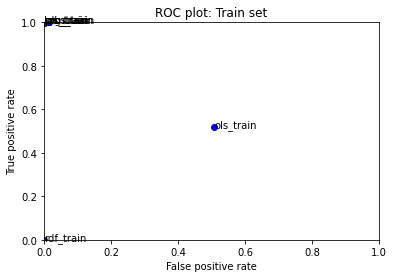

In [82]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train
]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [83]:
#FALSE NEGATIVES
ols_predictions = ols.predict(X_train)

In [84]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false negatives:
19
You're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay you're gay...
* * * * * * * * * 
574
do NOT get yourself killed, child 

you do not want to get yourself killed tampering with information on this topic, child.
* * * * * * * * * 
1483
You're such a slut.
* * * * * * * * * 
1534
who cares, they are worthless scum
* * * * * * * * * 
1553
Fucking whore 

You are such a dumb bitch i didn't make any changes whore!!!!!!!!!!!!!!!!!!!!!!!!!!!!
* * * * * * * * * 
2358
antandarus where do you live im sick of you blocking me
* * * * * * * * * 
2515
NLIGGERS GOT WHAT THEY HAD COMIN THE FUCK JUNGLE BUNNIES
* * * * * * * * * 
2636
"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes w

15681
YOU'RE A SAD ARSEHOLE. GET A LIFE.
* * * * * * * * * 
16639
So true 

Your the normal one. You must have a really satisfying life to spend over two years of your life contributing for free to an online encyclopedia. I can only imagine how your sex life is................ Bye loser ....................
* * * * * * * * * 
16640
Upskirting
I enjoy looking up women's skirts.
* * * * * * * * * 
17197
Utter nonsense. I questioned and I challenged and seemingly no-one has the balls.

STOP Wikipedia elitism.
* * * * * * * * * 
17720
shut up, jerk asshole.
* * * * * * * * * 
18055
Unfortunately? Wow, that is the way for a good administrator to act. Now I see what is going on. I should have looked at this page before I apologized. As for Yamla, you're still causing trouble with me, aren't you? and now you're makign administrators make big mistakes and accusing people of things like this. Leave me alone Yamla before I contact another administrator about you
* * * * * * * * * 
18242
"

Thank

24893
yeah so fuck you, there is a kid named wesley gibson in st. james and there are also two students known as goku and neo. Thanks )
* * * * * * * * * 
25581
OH SHUT UP YOU FUCCIN ASSHOLE! (  )
* * * * * * * * * 
25623
AND ON TOP OF THAT  eh, you're not worth it.
* * * * * * * * * 
25710
This is your Dad sam 

I'm worried about you.

Worried that your cock wont fit in my ass anymore!, OMFK LOLZ HAHA I SAID PEEENIS GORF GORF GORF GORF
* * * * * * * * * 
25849
Correction to Karljoos 
Karljoos, you ignorantly state that the phillipines is a hispanic country? How in the hell is that possible? Phillipino people are not spaniard nor have there been any admixture between spaniards and phillipines over the centuries. Are you ok?

Also, according to europeans (not ignorant americans), hispanic is an admixture of races in south america. Therefore, spaniards are not classified as hispanic. 

Then you state that Spanish culture has taken root in south america. This is not wholly true. Although 

39449
Vandalism

Eww ur gay lol.
* * * * * * * * * 
39700
"

 Why 

Why are you so stupid? ARKJEDI10  "
* * * * * * * * * 
40687
Wow 

Way to assume, my man.  I'm not saying that all of the stories about King Arthur were true, but Excalibur was a very real sword, and I do have it in my possession.  This is an irrefutable fact.  I have been interviewed by many historians and the like, and you're the first one that seems to think you know more than all of them.

Can you prove that I'm wrong?  Not only that my sword isn't the real thing, but that my claiming it is is such a travesty, that you cannot allow anyone else to see it at all?  I wonder what would happen, if the other Wikipedophiles got their poor little minds corrupted by a comment on a talk page, eh?

Referring to [].  Next time, do some research.  I won't bring it up again, but it's insulting to have someone like you treat me like a liar.
* * * * * * * * * 
41012
<-WHAT A FAGGOT, I'M GLAD HE'S DEAD!!!
* * * * * * * * * 
41598
H

47308
I dont give a fuck... it will get reposted so you think i give a flying fuck about deleting that article for a month or 2?
* * * * * * * * * 
47456
"

 I was so glad to read... 

this.

At least there are places in the world that ignore pathetic claims and whining from silly retarded bints with nothing better to do. A bit of rape never hurt anyone anyway. Who the hell do you feminists think you are anyway? Know your place!  —Preceding unsigned comment added by 79.75.179.141   

 Rape 

iz well funny, and is put dem fucking stupid womenz in their places innit. iz wot they is deserve 

 Jeffpw and Isaac 

ARE BOTH DEATH

LOL!  —Preceding unsigned comment added by 79.75.179.141   "
* * * * * * * * * 
48418
hello find me real nice sex pics soon as possible from this site
* * * * * * * * * 
48702
So someone pisses at me and I'm supposed to just smile and do as I'm told because they can't be bothered to write something that THEY feel is notable?
* * * * * * * * * 
48930
It would if you

55131
Kiss meee arse 

Like its SOOO convincing what you wrote. How about stick a stick up your fat assk.
* * * * * * * * * 
56353
"

 In documentary ""Fire and ice"" Nikita said that as much as 1 million red bandits died! (youtube)

 Fire and ice documentary, STALIN killed 90% of his generals and 80% of his colonels 

Shouldnt this important fact be mentioned about insane mad dictator STALIN?"
* * * * * * * * * 
57384
Proper Cunt 

Not my fault you are a silly cunt, god made you that way.
* * * * * * * * * 
57645
"

 J.Delanoy, YOU are an imbecilic bootkissing asshole: ""pwn"" my sockfarm? Fat chance, I've secretly vandalised some obscure pages. If Admins block me for this, they have no balls and no life. 

Do you even think you got a chance to ban me that easily? I've created socks to save up for the big day of vandalism! HAHA!

'nuff said.

"
* * * * * * * * * 
57807
LOL @ this loser editing his own bio to exclude Sanger. What a fucking faggot.
* * * * * * * * * 
57843
You represent

65077
socalled deicision isnt worth shit
* * * * * * * * * 
65922
Here we go again... Fuck you, !
* * * * * * * * * 
65940
culture killers
why on earth did you delete this page??? it has not violated any rules and is under construction!!!
* * * * * * * * * 
66145
"

 Fuck you. 

  How dare you? I am studying history at a top university and you have the nerve to tell me that I made that stuff up? Fuck you.   "
* * * * * * * * * 
66411
what kind of joke is this? 

you guys are like jokes came out of movies.
armenian, pontic, assyrian...
what is next?
lets see. hmm
german genocide..yep, during ww1, those who wanted to be on side of allies killed millions of germans.
british genocide.. in the war of gallipoli we killed hundreds of thousands britons systematically.
french genocide.. yes we killed them, too.
kurdish genocide. you know we always kill them, cause they are freedom fighters.
red indisn genocide.. we were the ones killed millions of native americans actually.

just because we did

75935
You're an idiot, MONGO. We should be reminding you. You're the one who started this mess by being uncivil. 174.89.52.62
* * * * * * * * * 
77001
Stay the fuck off my page
* * * * * * * * * 
77065
No, asshole. You copied and pasted text from a newspaper's website into a Wikipedia article. I reverted the addition of scare quotes to an article. I undid your WP:COPYVIO at an article I've been editing since 2011. You followed me to an article you've never edited before. If you're too fucking stupid to understand the difference, maybe you're too stupid to be editing Wikipedia. —  Talk/Stalk
* * * * * * * * * 
77177
Fuck You 

Hi Netmonger, Because of you I am not going to edit wikipedia any more, I dont care whether you are Mystic or Arsath or Lahiru_k , the fact is RaveenS is the one who suspected you to be Arsath, now you too seem to be good pals, Wikipedia is too fucking complicated for me. I am in Sri Lanka these days, and was concentrating on my book so was inactive in wikipedia, 

94555
penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 8===D~~penis 

110718
"

that's nice. go fuck yourselves, idiots. the fact that you can't absorb reality is no sweat off my back. you lose, i still win. good luck with your ""wikipedia fuckfest"" hahaha."
* * * * * * * * * 
110852
"
 LOOOOOOOOOOOOOOOL. JUST BECAUSE YOU EDIT ON WIKIPEDIA FOR FOUR YEARS NOW, DOESN'T MEAN I ASSUME YOU'RE HAVING FUN. YOU PROBABLY HAVE NO LIFE BECAUSE YOU DO THIS AS A ""LIVING"". ITS SO FUNNY HOW YOU GET BUTTHURT OVER THE STUPIDEST SHIT. LIKE YOU SAY THAT EXCESSIVE INFO ABOUT ""AWARDS"" IS RECKLESS. WELL MAYBE YOU SHOULD GET AN AWARD FOR BEING AN ASSHOLE ABOUT IT. MAYBE YOU HAVE SOME CHILL IN YOUR LIFE THEN YOU CAN STFU AND HAVE DIFFERENT OPINIONS LIKE ME. I DONT CARE WHAT YOU AND OTHER GUY THINKS. SO SORRY, YOU DO YOU. I DO ME."
* * * * * * * * * 
110878
fine then 

at least i don't like little boys like you do! BITCH!!!
* * * * * * * * * 
110955
Do you like big breast or big butts?
* * * * * * * * * 
111125
Im a fat cunt. Im a fat cunt. Im a fat cunt. Im a fat cunt. Im 

121263
Dutch penis yummuier especially if its mine!
* * * * * * * * * 
121457
YOU NEED SUM PUSSY GO PAY A GIRL SHE WILL TAKE CARE OF YOU, I SAY THIS BECUASE MOST PPL HERE ARE DORKS AND VIRGINS THATS NEVER EVEN TOUCHED THE A FEMALE
* * * * * * * * * 
121637
"

 Unblock Request: Fuck you, unblock me! 

{{unblock|HAHAAHAHAHAHAHAHAHA UNBLOCK ME OR I WILL VANDALISE MORE!!!!

It had been six years since we had graduated from college, and for the first time since graduation, all three of us were together again. From the enthusiastic hugs at the airport and then the conversation and laughter during the dinner we shared at a local restaurant on the way to my home, it was clear that while plenty of time had passed and we had kept in contact, the comfort and attraction between the three of us when all together in the same physical location was still undeniable.

Having returned to my cozy, semi-secluded home in the suburbs, we all sat in the living room, sipping wine and continuing the tales of o

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [79]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1684, 'TN': 13952, 'FP': 14786, 'FN': 1493, 'Accuracy': 0.4899263669121103, 'Precision': 0.10224650880388585, 'Recall': 0.5300598048473403, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [71]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1752, 'TN': 27840, 'FP': 898, 'FN': 1425, 'Accuracy': 0.9272129092903023, 'Precision': 0.6611320754716982, 'Recall': 0.5514636449480642, 'desc': 'svm_test'}


### MODEL: logistic regression

In [72]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1747, 'TN': 27803, 'FP': 935, 'FN': 1430, 'Accuracy': 0.9258969136769544, 'Precision': 0.65137956748695, 'Recall': 0.5498898331759522, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [73]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1181, 'TN': 27473, 'FP': 1265, 'FN': 1996, 'Accuracy': 0.897822340592198, 'Precision': 0.48282910874897794, 'Recall': 0.37173434057286747, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [74]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1836, 'TN': 27621, 'FP': 1117, 'FN': 1341, 'Accuracy': 0.9229829233902553, 'Precision': 0.6217406027768371, 'Recall': 0.5779036827195467, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [85]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1244, 'TN': 28640, 'FP': 98, 'FN': 1933, 'Accuracy': 0.9363622121259596, 'Precision': 0.9269746646795827, 'Recall': 0.3915643689014794, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [95]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 0, 'TN': 28738, 'FP': 0, 'FN': 3177, 'Accuracy': 0.9004543318188939, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

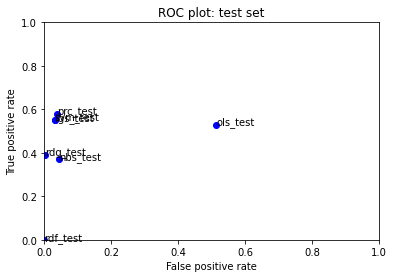

In [96]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [103]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_test.csv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   excl_pct  upper_ratio  dir_response
0       0.0            4             4
1       0.0            7             0
2       0.0            4             0
3       0.0            4             2
4       0.0            1        

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [104]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2146653260557311


In [105]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count,excl_pct,upper_ratio,dir_response
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0.0,4,4
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0.0,7,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0.0,4,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0.0,4,2
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0.0,1,0


In [106]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [107]:
my_submission.shape

(153164, 2)

In [110]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/geoff/Desktop/New_School/Semester_5/Machine_Learning/assignment1/iterations/toxiccomments_iter1_gstorr.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation